In [1]:
import sys
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow.dataset as ds

sys.path.append(str(Path.cwd().parent))
from config import PATH_KIOSK_USER_PATTERNS_FOLDER, PATH_KIOSK_USER_PATTERNS_REPO

# Example usage
ekdat02_path = PATH_KIOSK_USER_PATTERNS_FOLDER / "working/raw" / "ekdat02"
ekdat02_supplemental_path = PATH_KIOSK_USER_PATTERNS_FOLDER / "working/raw" / "ekdat02-supplemental"

In [2]:
# Load the Parquet dataset ekdat02
ekdat02_dataset = ds.dataset(ekdat02_path, format="parquet")


# Print the count of rows in the dataset ekdat02
print(f"ekdat02 dataset row count: {ekdat02_dataset.count_rows()}")

ekdat02 dataset row count: 12193862


In [3]:
# Load the Parquet dataset ekdat02_supplemental
ekdat02_supplemental_dataset = ds.dataset(ekdat02_supplemental_path, format="parquet")


# Print the count of rows in the dataset ekdat02_supplemental
print(f"ekdat02_supplemental dataset row count: {ekdat02_supplemental_dataset.count_rows()}")

ekdat02_supplemental dataset row count: 131879774


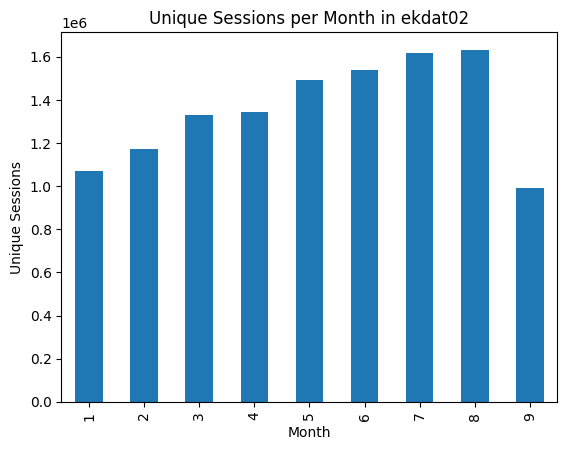

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Load only the required columns to reduce memory usage
scanner = ekdat02_dataset.scanner(columns=['session_id_mask', 'session_received_utc'])
ekdat02_df = scanner.to_table().to_pandas()

# Ensure 'session_received_utc' is datetime, then extract the month
ekdat02_df['session_received_utc'] = pd.to_datetime(ekdat02_df['session_received_utc'], errors='coerce')
ekdat02_df['month'] = ekdat02_df['session_received_utc'].dt.month

# Group by month and count unique session IDs
sessions_per_month = ekdat02_df.groupby('month')['session_id_mask'].nunique()
sessions_per_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Unique Sessions')
plt.title('Unique Sessions per Month in ekdat02')
plt.show()

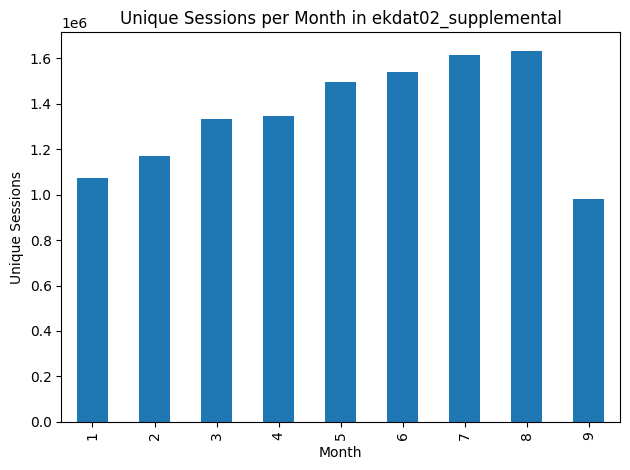

In [7]:
# Plot the number of unique sessions per month in ekdat02_supplemental
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load only the required columns to reduce memory usage
scanner = ekdat02_supplemental_dataset.scanner(columns=['session_id_mask', 'date_time'])
ekdat02_supplemental_df = scanner.to_table().to_pandas()

# Step 2: Ensure 'date_time' is datetime, then extract the month
ekdat02_supplemental_df['date_time'] = pd.to_datetime(ekdat02_supplemental_df['date_time'], errors='coerce')
ekdat02_supplemental_df['month'] = ekdat02_supplemental_df['date_time'].dt.month

# Step 3: Group by month and count unique session IDs
sessions_per_month_supp = ekdat02_supplemental_df.groupby('month')['session_id_mask'].nunique()

# Step 4: Plot
sessions_per_month_supp.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Unique Sessions')
plt.title('Unique Sessions per Month in ekdat02_supplemental')
plt.tight_layout()
plt.show()

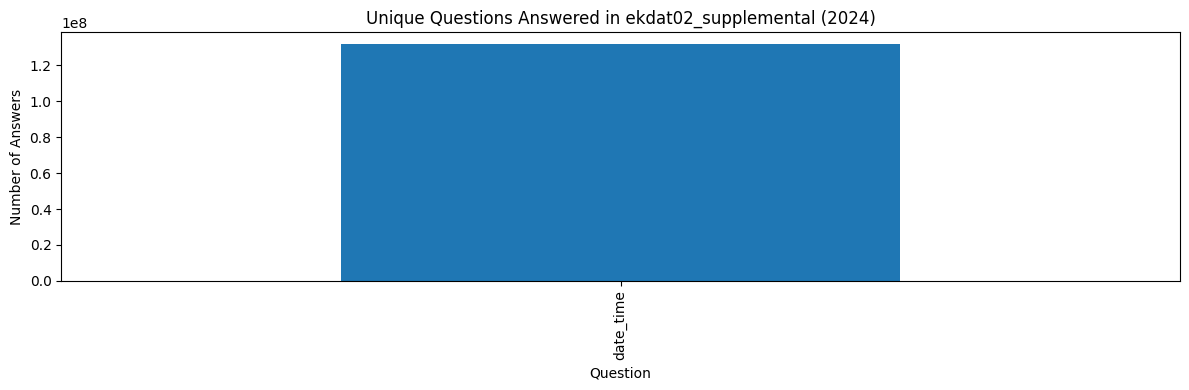

In [9]:
# Ensure 'date_time' is datetime
ekdat02_supplemental_df['date_time'] = pd.to_datetime(ekdat02_supplemental_df['date_time'], errors='coerce')

# Filter for 2024
df_2024 = ekdat02_supplemental_df[ekdat02_supplemental_df['date_time'].dt.year == 2024]

# Identify question columns (exclude metadata)
metadata_cols = [
    'session_id_mask', 'account_id_mask', 'pseudo_member_id',
    'session_received_utc', 'session_started_local_time', 'timezone_offset',
    'location_name', 'street1', 'street2', 'city', 'state', 'zipcode',
    'birth_year', 'gender', 'ethnicity', 'year', 'month'
]
question_cols = [col for col in df_2024.columns if col not in metadata_cols]

# Count how many times each question was answered (non-null)
question_counts = df_2024[question_cols].notnull().sum().sort_values(ascending=False)

# Plot
question_counts.plot(kind='bar', figsize=(12, 4))
plt.xlabel('Question')
plt.ylabel('Number of Answers')
plt.title('Unique Questions Answered in ekdat02_supplemental (2024)')
plt.tight_layout()
plt.show()

### Initial user patterns

There are many ways to capture user patterns. One such way is to conduct an unsupervised cluster analysis of users by what questions they chose to respond to.

1. Subset the patients for June to September 2024
2. Create a wide dataset such that each session is a row, and all questions associated with that session and its associated value is the column. Feel free to drop extra columns before that. Do let me know if you have any questions.
3. Fill in the missing values for all questions with 0
4. Run a cluster analysis so that you can see whether users responded to groups of questions and what those questions are: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html


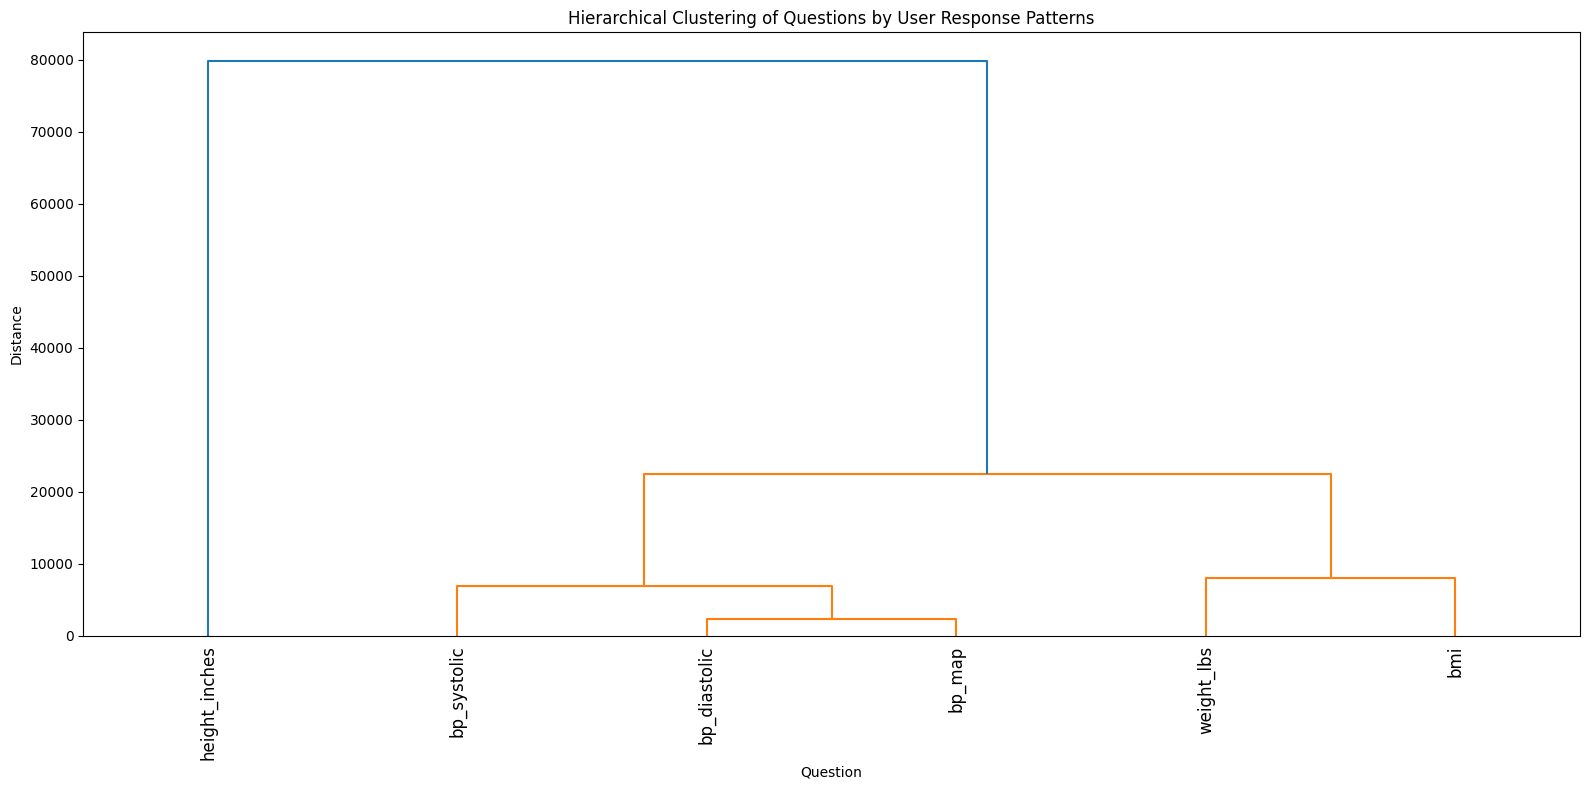

In [14]:
import sys
from pathlib import Path
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from datetime import datetime
import numpy as np
import os

# --- CONFIG ---
dataset_path = "/Users/carolinechizak/Library/CloudStorage/OneDrive-SharedLibraries-Emory/Varghese, Jithin Sam - Pursuant User Profiles/working/raw/ekdat02"

# --- STEP 1: Subset patients for June–September 2024 ---
dataset = ds.dataset(dataset_path, format="parquet")
df = dataset.to_table().to_pandas()
df["session_received_utc"] = pd.to_datetime(df["session_received_utc"])
mask = (df["session_received_utc"] >= datetime(2024, 6, 1)) & (df["session_received_utc"] <= datetime(2024, 9, 30))
df = df[mask]

# --- STEP 2: Create wide dataset ---
# Drop metadata columns, keep only response variables + IDs
metadata_cols = [
    'session_id_mask', 'account_id_mask', 'pseudo_member_id',
    'session_received_utc', 'session_started_local_time', 'timezone_offset',
    'location_name', 'street1', 'street2', 'city', 'state', 'zipcode',
    'birth_year', 'gender', 'ethnicity', 'year', 'month'
]
question_cols = [col for col in df.columns if col not in metadata_cols]

# Filter only session-level responses (wide format)
wide_df = df[["pseudo_member_id", "session_id_mask"] + question_cols].copy()

# Drop duplicates just in case
wide_df = wide_df.drop_duplicates(subset=["pseudo_member_id", "session_id_mask"])

# --- STEP 3: Fill missing question values with 0 ---
question_only_df = wide_df[question_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
wide_df[question_cols] = question_only_df

# --- STEP 4: Sample sessions + cluster questions ---
sample_df = wide_df.groupby(['pseudo_member_id', 'session_id_mask']).first().reset_index()
sample_df = sample_df.sample(n=min(20000, len(sample_df)), random_state=42)

# Only keep response columns for clustering
X = sample_df[question_cols]

# Transpose so rows = questions
X_t = X.T

# Hierarchical clustering
Z = linkage(X_t, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(Z, labels=X_t.index, leaf_rotation=90)
plt.title('Hierarchical Clustering of Questions by User Response Patterns')
plt.xlabel('Question')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()